# PS1
## Siyuan Peng

In [21]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import graphviz
from dask import delayed
from dask import compute
import dask.array as da
from statistics import mean

## 1

## (a)

In [2]:
bq_data = np.loadtxt('data\BQmat_orig.txt', delimiter=',')

<IPython.core.display.Javascript object>


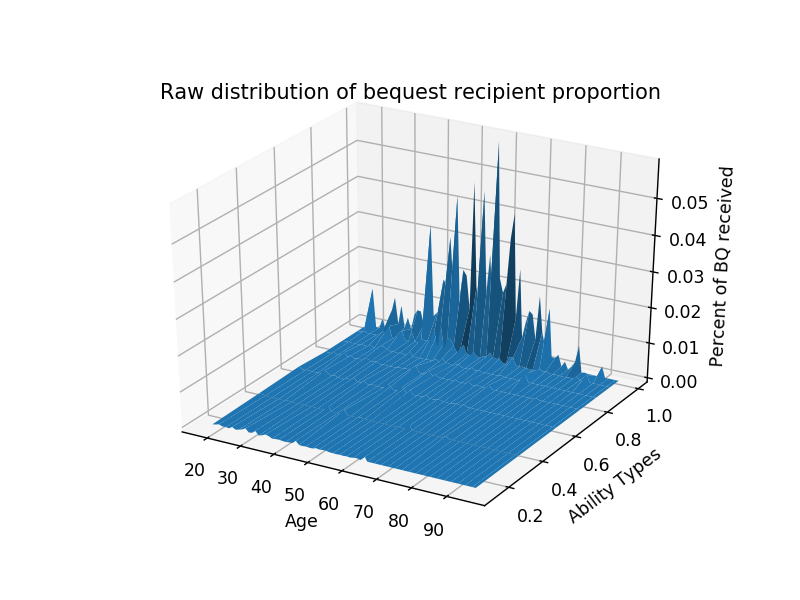

Text(0.5, 0, 'Percent of BQ received')

In [3]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
prcntl = np.array([0.25,0.25,0.2,0.1,0.1,0.09,0.01])
prcntl_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
age_vec = np.arange(18,96)
income_mat, age_mat = np.meshgrid(prcntl_mdpts, age_vec)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

## (b)

In [15]:
def simulation(n):
    ages_vec = np.arange(18, 96)
    abils_midpt = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
    prop_mat_inc = np.sum(bq_data, axis=0)
    prop_mat_age = np.sum(bq_data, axis=1)
    age_probs = np.random.multinomial(n, prop_mat_age)
    income_probs = np.random.multinomial(n, prop_mat_inc)
    age_freq = np.array([])
    inc_freq = np.array([])

    # creating a distribution of age values
    for age, num_s in zip(ages_vec, age_probs):
        vec_age_s = np.ones(num_s)
        vec_age_s *= age
        age_freq = np.append(age_freq, vec_age_s)

    # creating a distribution of ability type values
    for abil, num_j in zip(abils_midpt, income_probs):
        vec_abil_j = np.ones(num_j)
        vec_abil_j *= abil
        inc_freq = np.append(inc_freq, vec_abil_j)
    return np.vstack((age_freq, inc_freq))
Data_sim = simulation(70000)

0.03


<IPython.core.display.Javascript object>


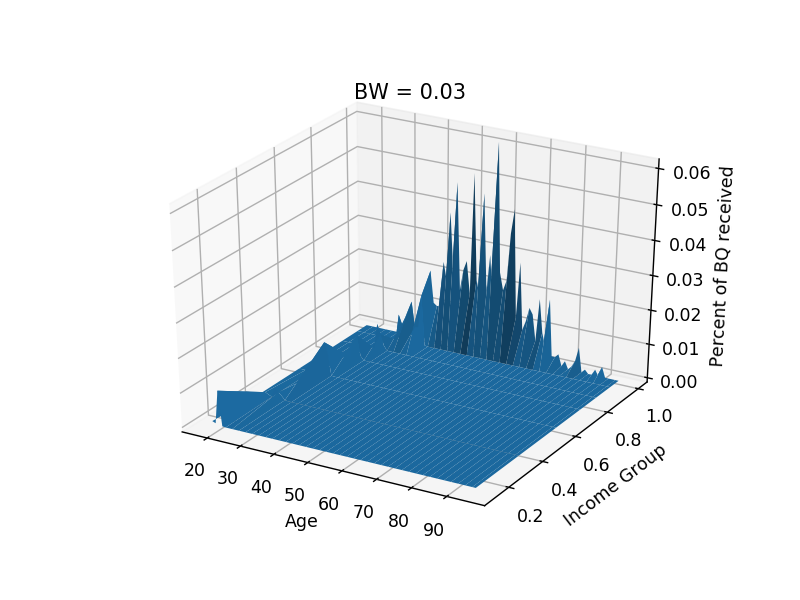

Text(0.5, 0, 'Percent of BQ received')

In [17]:
bw_best = 0.01
loss_best = np.inf
for i in range(20):
    bw = (i+1)*0.01
    kde = gaussian_kde(Data_sim, bw_method = bw)
    coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
    density = np.reshape(kde(coords), age_mat.shape)
    density_scaled = density/density.sum()
    loss = ((density_scaled - bq_data)**2).sum()
    if loss < loss_best:
        loss_best = loss
        bw_best = bw
print(bw_best)
kde = gaussian_kde(Data_sim, bw_method = bw_best)
coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
density = np.reshape(kde(coords), age_mat.shape)
density_scaled = density/density.sum()
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(age_mat, income_mat, density_scaled)
ax.set_title('BW = {:.2f}'.format(bw_best))
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

From the calculation, it is clear that the bide width of 0.03 is best with least squared error.

In [18]:
print("Estimated density for bequest recipients who are age 61 in the 6th lifetime income category = ", density_scaled[43][5])

Estimated density for bequest recipients who are age 61 in the 6th lifetime income category =  5.9048892447603e-51


# 2

## (a)

In [19]:
df = pd.read_csv('data/Auto.csv', na_values='?')
df.dropna(inplace=True)
df.columns=['mpg', 'cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn','name']
df.head()

,mpg,cyl,displ,hpwr,wgt,accl,yr,orgn,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [20]:
df['mpg_high'] = 0
df.mpg_high[df.mpg>=df.mpg.median()] = 1
df['orgn1'] = (df.orgn==1).astype(int)
df['orgn2'] = (df.orgn==2).astype(int)

In [39]:
import time
N_bs = 100

err_vec = np.zeros(N_bs)
X = df[['cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn1', 'orgn2']].values
y = df.mpg_high.values

time_start1 = time.clock()
for bs_ind in range(N_bs):
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.35, random_state=100+bs_ind)
    LogReg = LogisticRegression(n_jobs = None)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    err_vec[bs_ind] = (y_test == y_pred).mean()
    
mean_err = err_vec.mean()
time_end1 = time.clock()

print('The average error rate =', mean_err)
print('computation time =',time_end1-time_start1,'seconds')

The average error rate = 0.89768115942029
computation time = 0.1660863999995854 seconds


## (b)

In [26]:
def paral_bs(bs_ind, seed, X, y):    
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.35, random_state=seed+bs_ind)
    LogReg = LogisticRegression(n_jobs = None)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    return (y_test == y_pred).mean()

In [35]:
N_bs = 100
err_vec = []
X = df[['cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn1', 'orgn2']].values
y = df.mpg_high.values

time_start2 = time.clock()
for bs_ind in range(N_bs):
    sample_MSE = delayed(paral_bs(bs_ind, 100, X, y))
    err_vec.append(sample_MSE)

mean_err = delayed(mean)(err_vec)
mean_err = compute(mean_err)
time_end2 = time.clock()

print('The average error rate =', mean_err[0])
print('computation time =',time_end2-time_start2,'seconds')

The average error rate = 0.8976811594202898
computation time = 0.16368680000050517 seconds
